In [1]:
import os
import glob
import cv2
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt

# Setup

In [2]:
def read_bag_file(file_name):
    pipe = rs.pipeline()
    cfg = rs.config()
    cfg.enable_device_from_file(file_name, repeat_playback=False)
    profile = pipe.start(cfg)
    playback = profile.get_device().as_playback()
    playback.set_real_time(False) # False: no frame drop
    
    # Get the frame shape of the color sensor
    frames = pipe.wait_for_frames()
    color_frame = frames.get_color_frame()
    frame_shape = (color_frame.get_height(), color_frame.get_width())

    return pipe, cfg, profile, playback, frame_shape

In [3]:
# Read the bag file
# file_name = "..\\Dataset\\_realsense\\Data_realsense1\\20240322_123504.bag"
# file_name = "..\\Dataset\\tests\\60fps_424x240.bag"
file_name = "..\\Dataset\\tests\\60fps_640x480.bag"

pipe, cfg, profile, playback, frame_shape = read_bag_file(file_name)
duration = playback.get_duration()
print("Video duration: ", duration)
print("Frame shape: ", frame_shape)

Video duration:  0:01:16.408926
Frame shape:  (480, 640)


In [4]:
# Function to align the depth frame to the color frame
def align_frames(frames):
    align = rs.align(rs.stream.color)
    aligned_frames = align.process(frames)
    aligned_depth = aligned_frames.get_depth_frame()
    aligned_color = aligned_frames.get_color_frame()
    return aligned_depth, aligned_color

In [5]:
colorizer = rs.colorizer()

# Read the full stream
pipe, cfg, profile, playback, frame_shape = read_bag_file(file_name)
num_frames = 0
wait_key = 1

try:
    while True:
        # Wait for a coherent pair of frames: depth and color
        frames = pipe.wait_for_frames()

        # Align the depth frame to color frame so they have the same shape
        aligned_depth, aligned_color = align_frames(frames)
        depth_color_frame = colorizer.colorize(aligned_depth)

        depth_color_image = np.asanyarray(depth_color_frame.get_data())
        color_image = np.asanyarray(aligned_color.get_data())

        # Stack both images horizontally
        images = np.hstack((color_image, depth_color_image))
        cv2.imshow("Images", images)

        key = cv2.waitKey(wait_key)

        # Press esc close the image window
        if key == 27:
            break

        # Press s to write the color_image on disk
        if key == ord('s'):
            cv2.imwrite(".\color_images\motion_blur" + str(num_frames) + ".png", color_image)
            cv2.imwrite(".\depth_images\image" + str(num_frames) + ".png", depth_color_image)

        # Press d to view the video frame by frame
        if key == ord('d'):
            if wait_key == 0:
                wait_key = 1
            else:
                wait_key = 0

        num_frames += 1

# Catch exception if the stream is ended
except RuntimeError:
    print("Stream ended")
        
finally:
    # Stop streaming
    cv2.destroyAllWindows()
    pipe.stop()

print("Total number of frames: ", num_frames)

Total number of frames:  77


# Extract height of the participants

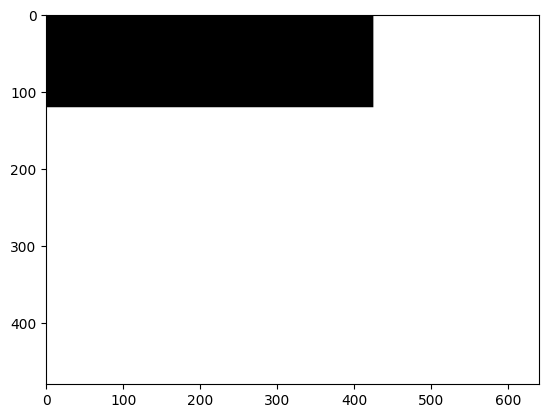

In [6]:
# Create a mask to remove the top part of the image
mask = np.zeros(frame_shape, dtype=np.uint8)
cv2.rectangle(mask, (0, 0), (424, 120), (255, 255, 255), -1)
mask = cv2.bitwise_not(mask)
plt.imshow(mask, cmap='gray')
plt.show()

In [7]:
# Setup the aruco detector
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_ARUCO_MIP_36h12)
aruco_params = cv2.aruco.DetectorParameters()

aruco_params.polygonalApproxAccuracyRate = 0.05
aruco_params.errorCorrectionRate = 0.2

detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params) 

In [8]:
def sign(p1, p2, p3):
    return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

def is_inside(p, a, b, c, d):
    b1 = sign(p, a, b) < 0.0
    b2 = sign(p, b, c) < 0.0
    b3 = sign(p, c, d) < 0.0
    b4 = sign(p, d, a) < 0.0
    return ((b1 == b2) and (b2 == b3) and (b3 == b4))

def is_point_in_square(A, B, C, D, P):
    return is_inside(P, A, B, C, D)

In [13]:
camera_height = 2.49 # meters 

pipe, cfg, profile, playback, frame_shape = read_bag_file(file_name)
num_frames = 0
wait_key = 1

# Empty the distance_images folder
files = glob.glob('distance_images/*')
for f in files:
    os.remove(f)

# Data structure to store the a list of height for every aruco code id
heights = {}

try:
    while True:
        frames = pipe.wait_for_frames()
        # Align the depth frame to color frame so they have the same shape
        aligned_depth, aligned_color = align_frames(frames)

        color_image = np.asanyarray(aligned_color.get_data())
        # color_image = cv2.bitwise_and(color_image, color_image, mask=mask)

        corners, ids, rejected = detector.detectMarkers(color_image)
        output_image = color_image.copy()
        cv2.aruco.drawDetectedMarkers(output_image, corners, ids)

        for k in range(len(corners)):
            c = corners[k][0]
            A = c[0]
            B = c[1]
            C = c[2]
            D = c[3]
            distances = []

            # Pick 100 random points inside the aruco code square to calculate the average distance
            min_x = int(min(A[0], B[0], C[0], D[0]))
            max_x = int(max(A[0], B[0], C[0], D[0]))
            min_y = int(min(A[1], B[1], C[1], D[1]))
            max_y = int(max(A[1], B[1], C[1], D[1]))

            num_points = 0
            while num_points < 100:
                x = np.random.randint(min_x, max_x + 1) 
                y = np.random.randint(min_y, max_y + 1)
                if is_point_in_square(A, B, C, D, (x, y)):
                    # Draw the point on the image
                    cv2.circle(output_image, (x, y), 2, (0, 255, 0), -1)
                    z = aligned_depth.get_distance(x, y)
                    distances.append(z)
                    num_points += 1

            distance = np.mean(distances)
            height = camera_height - distance
            cv2.putText(output_image, "Height: {:.2f} m".format(height), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            
            if not ids[k][0] in heights:
                heights[ids[k][0]] = []
                
            heights[ids[k][0]].append(height)

        cv2.imshow("Output", output_image)
        key = cv2.waitKey(wait_key)

        # Press esc close the image window
        if key == 27:
            break

        # Press d to view the video frame by frame
        if key == ord('d'):
            if wait_key == 0:
                wait_key = 1
            else:
                wait_key = 0

        num_frames += 1
           
# Catch exception if the stream is ended
# except RuntimeError:
#     print("Stream ended")
        
finally:
    # Stop streaming
    cv2.destroyAllWindows()
    pipe.stop()

In [22]:
def remove_outliers(data, m=2):
    # Z-score method
    data = np.array(data)
    mean = np.mean(data)
    std = np.std(data)
    filtered_data = [x for x in data if abs(x - mean) / std < m]
    return filtered_data

def calculate_mean_height(heights):
    mean_heights = {}

    for key, height_list in heights.items():
        filtered_heights = remove_outliers(height_list)
        if filtered_heights:
            mean_heights[key] = np.mean(filtered_heights)

    return mean_heights

# Remove outliers and calculate the mean height for each aruco code id
mean_heights = calculate_mean_height(heights)
print(mean_heights)

{87: 1.8944999516010284, 24: 1.8134999513626098, 19: 1.8796249717473983, 67: 1.904999962945779}


# Attemping to enhance Aruco codes

In [25]:
camera_height = 2.65 # meters => NOT SURE ABOUT THIS VALUE

pipe, cfg, profile, playback, frame_shape = read_bag_file(file_name)
num_frames = 0
wait_key = 1

# Empty the distance_images folder
files = glob.glob('distance_images/*')
for f in files:
    os.remove(f)

# Data structure to store the a list of height for every aruco code id
heights = {}

try:
    while True:
        frames = pipe.wait_for_frames()

        # Align the depth frame to color frame so they have the same shape
        aligned_depth, aligned_color = align_frames(frames)
        color_image = np.asanyarray(aligned_color.get_data())
        depth_color_frame = colorizer.colorize(aligned_depth)
        depth_color_image = np.asanyarray(depth_color_frame.get_data())

        # Apply the mask to the depth image
        depth_color_image = cv2.bitwise_and(depth_color_image, depth_color_image, mask=mask)

        # Convert the image to HSV color space
        hsv_image = cv2.cvtColor(depth_color_image, cv2.COLOR_BGR2HSV)

        # Define the range for red color in HSV
        # Note: Red can appear in two ranges in HSV
        lower_red1 = np.array([0, 70, 50])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 70, 50])
        upper_red2 = np.array([180, 255, 255])

        # Create masks for red color
        red_mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
        red_mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)

        # Combine the two masks
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)

        # Apply the mask to the original image
        result = cv2.bitwise_and(depth_color_image, depth_color_image, mask=red_mask)

        # Convert the result to grayscale and apply thresholding
        gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        _, thresh_result = cv2.threshold(gray_result, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Apply the closing morphological operation to fill in holes
        kernel = np.ones((30, 30), np.uint8)
        closed_result = cv2.morphologyEx(thresh_result, cv2.MORPH_CLOSE, kernel)

        # Find contours of the red square
        contours, _ = cv2.findContours(closed_result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create a mask to keep only the aruco code in the color image
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 100*100 and area < 200*200:
                x, y, w, h = cv2.boundingRect(contour)  
                arcuo_code_mask = np.zeros(frame_shape, dtype=np.uint8)
                
                # Expand the bounding box by 50 pixels
                sz = (w + h) // 2
                x1 = max(0, x - 25)
                y1 = max(0, y - 25)
                x2 = min(640, x + sz + 25)
                y2 = min(480, y + sz + 25)
                cv2.rectangle(arcuo_code_mask, (x1, y1), (x2, y2), (255, 255, 255), -1)
                color_image = cv2.bitwise_and(color_image, color_image, mask=arcuo_code_mask)

                cv2.imwrite("color_images\motion_blur_mask\motion_blur" + str(num_frames) + ".png", color_image)

        cv2.imshow("Output", color_image)
        key = cv2.waitKey(wait_key)

        # Press esc close the image window
        if key == 27:
            break

        # Press d to view the video frame by frame
        if key == ord('d'):
            if wait_key == 0:
                wait_key = 1
            else:
                wait_key = 0

        num_frames += 1
           
# Catch exception if the stream is ended
except RuntimeError:
    print("Stream ended")
        
finally:
    # Stop streaming
    cv2.destroyAllWindows()
    pipe.stop()

In [ ]:
# image = cv2.imread("color_images\motion_blur\motion_blur1229.png", cv2.IMREAD_GRAYSCALE)
# corners, ids, rejected = detector.detectMarkers(image)
# output_image = image.copy()
# if corners is not None:
#     print("Detected markers: ", len(corners))

# cv2.aruco.drawDetectedMarkers(output_image, corners, ids)
# cv2.imshow("Output", output_image)

# # Show the marker id image
# marker_id = ids[0][0]
# print("Marker ID: ", marker_id)
# marker_size = 200  # Taille de l'image générée
# aruco_marker_image = cv2.aruco.generateImageMarker(aruco_dict, marker_id, marker_size)
# cv2.imshow("Marker", aruco_marker_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()